# Maximum error experiment

Load data.

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [3]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        ConstantOracle, RandomOracle, DockingOracle, \
        CatBoostOracle, RDKitOracle, NoisyOracle, \
        ReactionStepOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    constant_oracle = ConstantOracle('Constant', constant=1)
    random_oracle = RandomOracle('Random')
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    reaction_step_oracle = ReactionStepOracle('Reaction Steps')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle, constant_oracle, random_oracle, reaction_step_oracle

In [25]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
(
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    constant_oracle,
    random_oracle,
    reaction_step_oracle
) = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))
constant_utility = ClassicUtilityFunction(
    constant_oracle, ideal=(3, 4), acceptable=(2, 5))
random_utility = ClassicUtilityFunction(
    random_oracle, ideal=(3, 4), acceptable=(2, 5))

# Assemble assays and surrogate models
from dgym.envs.oracle import GaussianOracle
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    GaussianOracle(f'Noisy {pIC50_oracle.name}', loc=7.460298232446733, scale=100),
    GaussianOracle(f'Noisy {log_P_oracle.name}', loc=2.223214738326521, scale=100),
    GaussianOracle(f'Noisy {log_S_oracle.name}', loc=-3.752548978069126, scale=100),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [28]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [34]:
import warnings
warnings.filterwarnings("ignore")

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in assays:
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

[]
unidock --receptor ../../dgym-data/dockstring_targets/ABL1_target.pdbqt --ligand_index /tmp/tmpktd12997/ligands.txt --dir /tmp/tmpktd12997 --search_mode detailed --scoring vina --seed 5 --center_x 15.851 --center_y 14.647 --center_z 3.904 --size_x 22.5 --size_y 22.5 --size_z 22.5
CompletedProcess(args='unidock --receptor ../../dgym-data/dockstring_targets/ABL1_target.pdbqt --ligand_index /tmp/tmpktd12997/ligands.txt --dir /tmp/tmpktd12997 --search_mode detailed --scoring vina --seed 5 --center_x 15.851 --center_y 14.647 --center_z 3.904 --size_x 22.5 --size_y 22.5 --size_z 22.5', returncode=0, stdout='Uni-Dock v1.1.0\n\nIf you used Uni-Dock in your work, please cite:               \n \nYu, Y., Cai, C., Wang, J., Bo, Z., Zhu, Z., & Zheng, H. (2023). \nUni-Dock: GPU-Accelerated Docking Enables Ultralarge Virtual Screening. \nJournal of Chemical Theory and Computation.                    \nhttps://doi.org/10.1021/acs.jctc.2c01145                       \n\nTang, S., Chen, R., Lin, M., L

Instantiate Environment and Agent.

In [35]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 8, 'parameters': {'strategy': 'grow', 'size': 5}}
design_replace = {'name': 'design', 'batch_size': 8, 'parameters': {'strategy': 'replace', 'size': 5, 'temperature': 0.2}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 8 * 5, 'parameters': {'batch_size': 40}}
make = {'name': 'make', 'batch_size': 8}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8}
design_and_score = [design_replace, score]

sequence = [design_replace, score, design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.25),
    utility_function = utility_agent
)

In [36]:
def display_best(experiment):
    import numpy as np
    observations = experiment.drug_env.library
    utilities = experiment.drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from dgym.experiment import Experiment

experiment = Experiment(
    drug_env=drug_env,
    drug_agent=drug_agent
)

import io
from contextlib import redirect_stdout
f = io.StringIO()
# with redirect_stdout(f):
result = experiment.run()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Created action
{'name': 'design', 'parameters': {'strategy': 'replace', 'size': 5, 'temperature': 0.2}, 'molecules': [3, 0, 2, 4, 1]}
['Tested', 'Tested', 'Tested', 'Tested', 'Tested']
-2.924406603997481
Created action
{'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'parameters': {'batch_size': 40}, 'molecules': [5, 6, 7, 8, 9, 10, 11, 26, 12, 16, 13, 14, 15, 17, 29, 18, 19, 20, 21, 22, 23, 24, 25, 28, 27]}
['Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed', 'Designed']
{'batch_size': 40}
[15.39122818343478, 131.59820709738733, 108.48741165905244, 9.367315890120713, -74.33077849880918, -25.428813466897843, -8.120277872970568, -83.08695874175486, 1.317108876889188, 8.833481043971057, -129.8499963449542, -117.9702911030028, -34.13040062684362

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

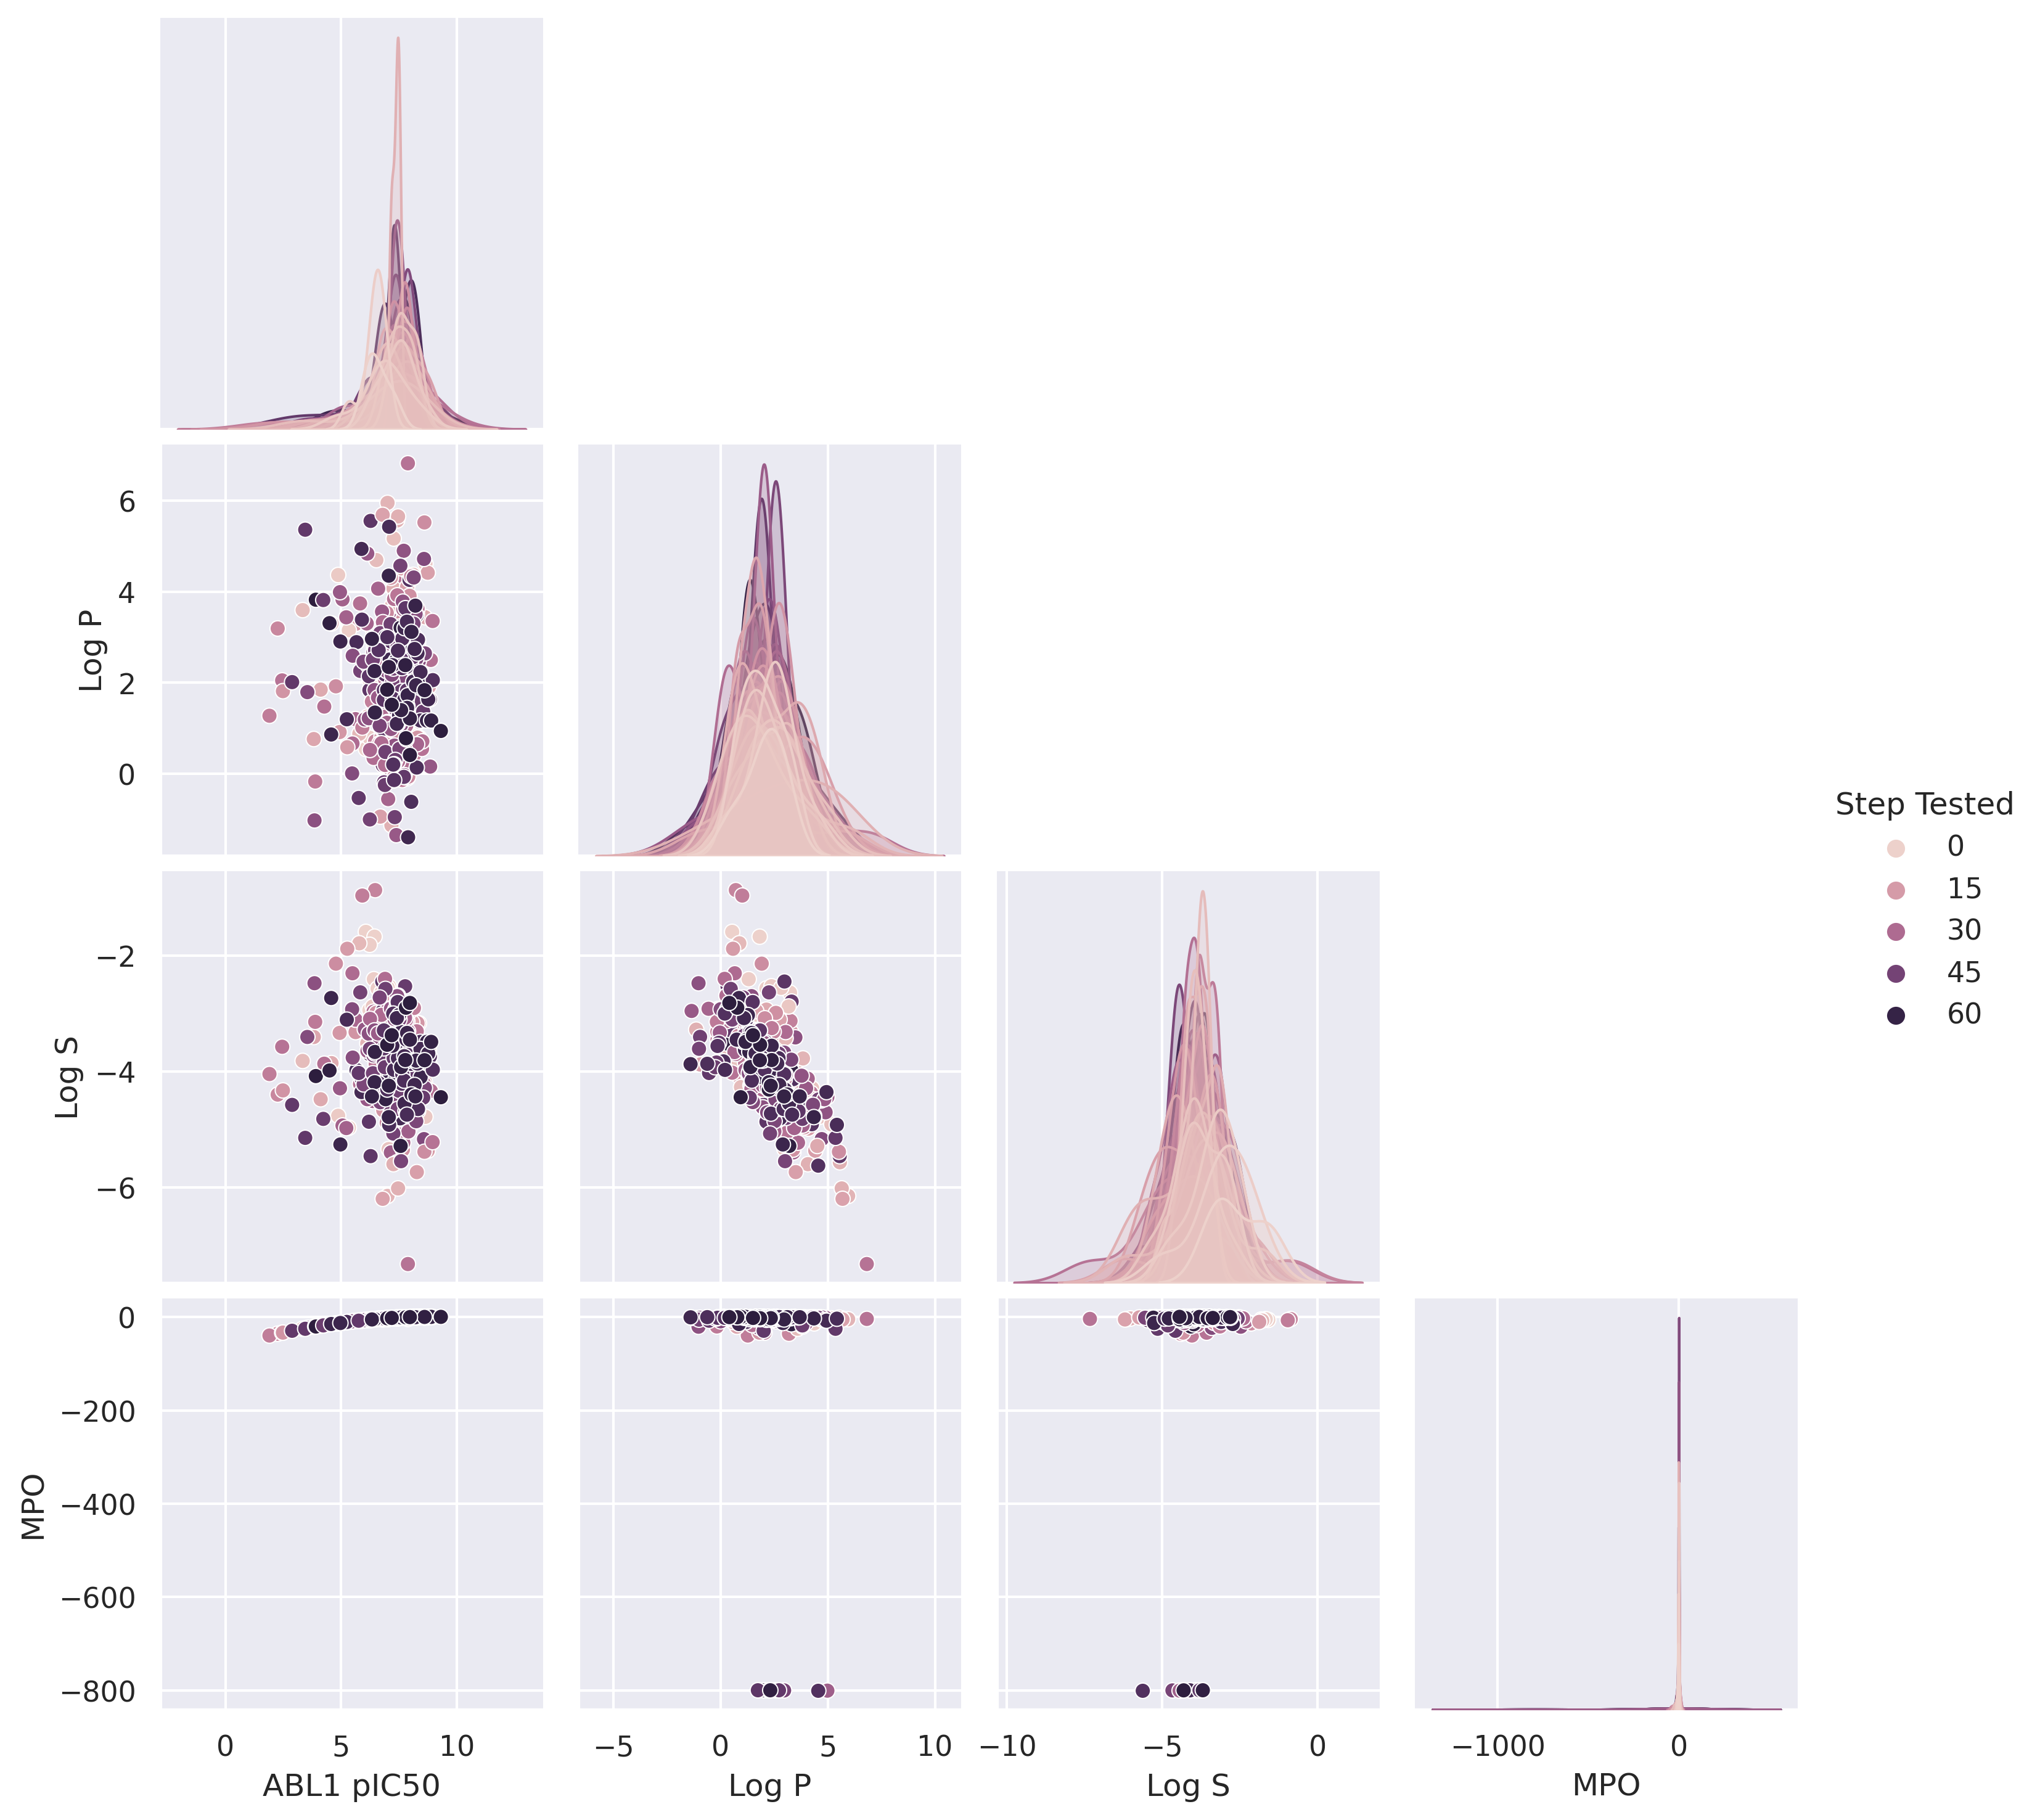

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(dpi=300)

pairplot_df = experiment.drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = experiment.drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [11]:
max_timestep = int(experiment.drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': int(t)})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

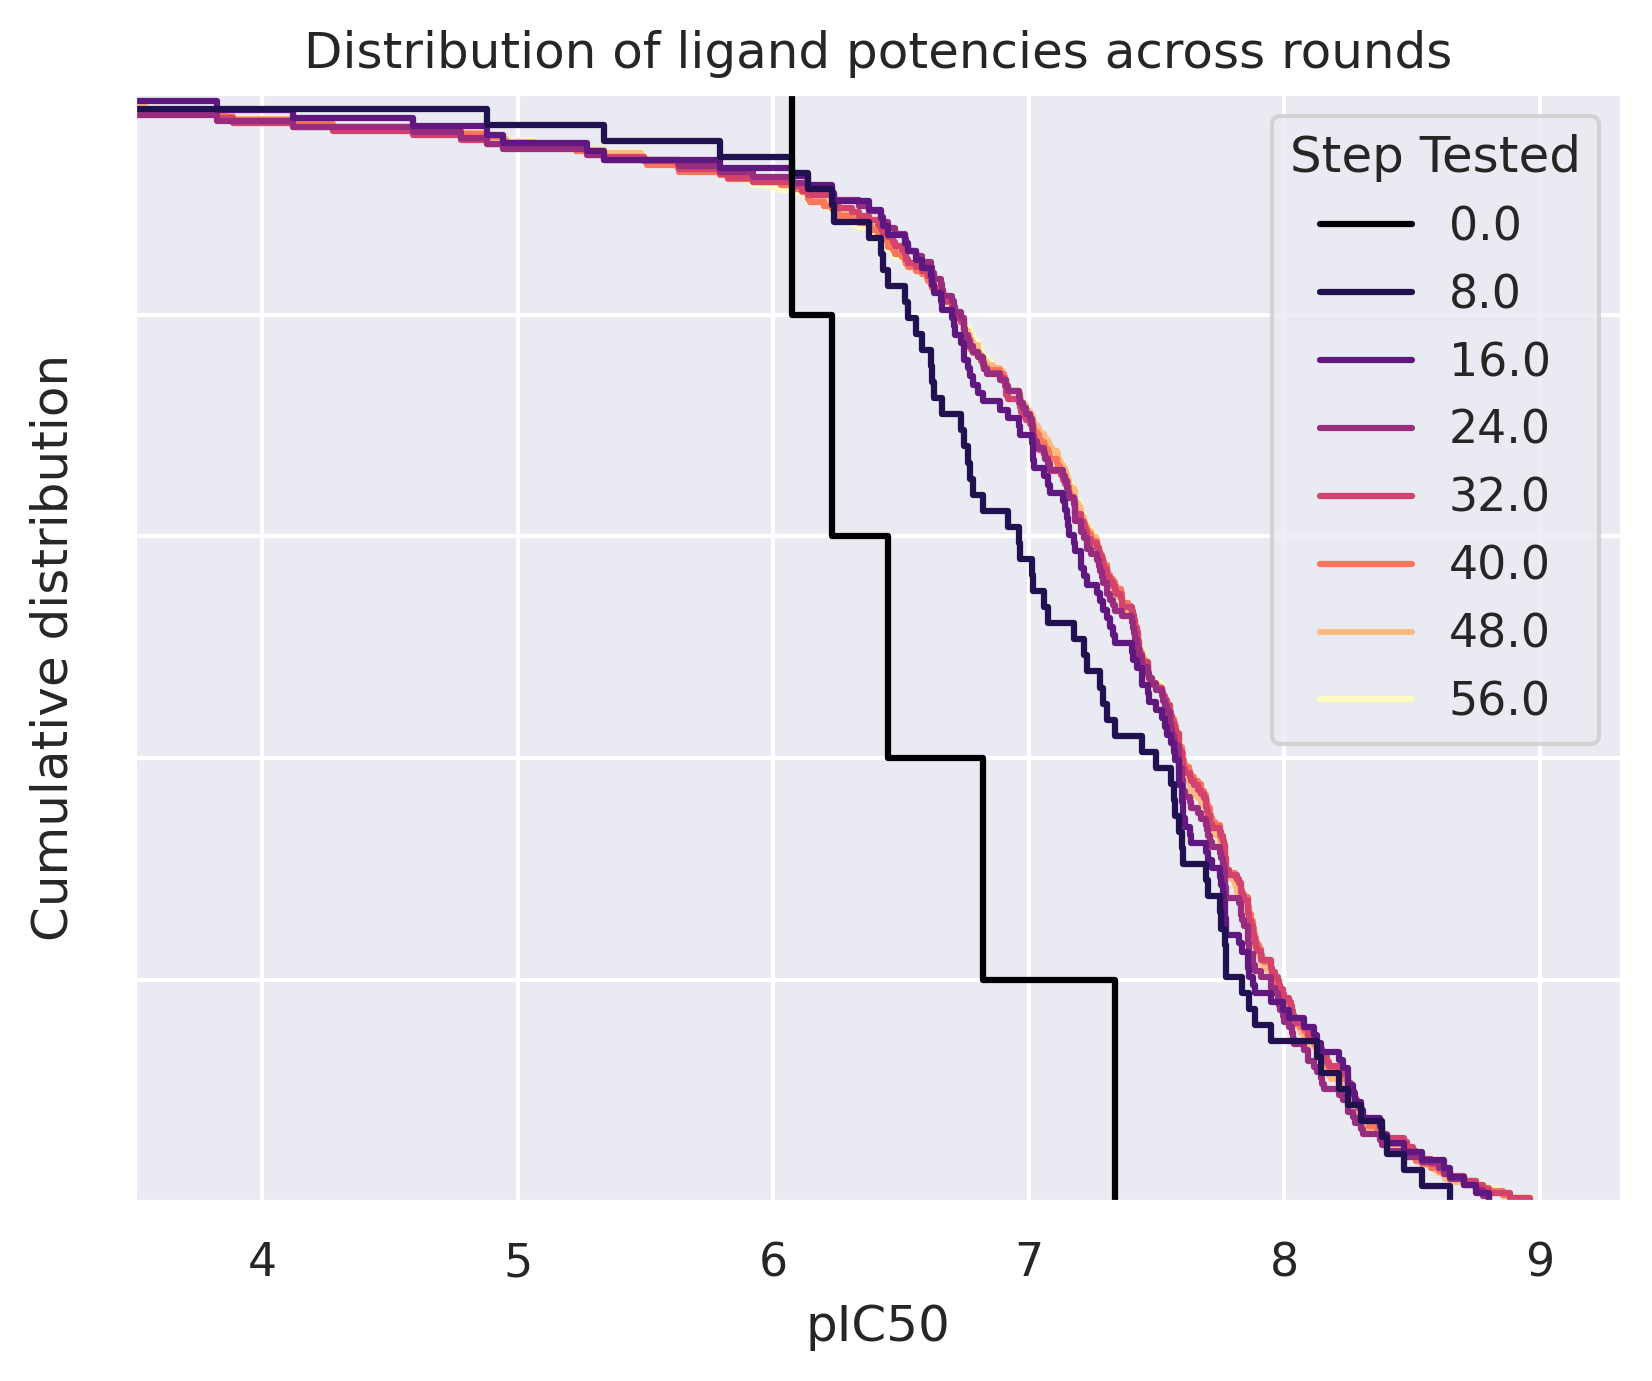

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('`Step Tested` % 8 == 0'),
    x='pIC50',
    hue='Step Tested',
    palette='magma',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

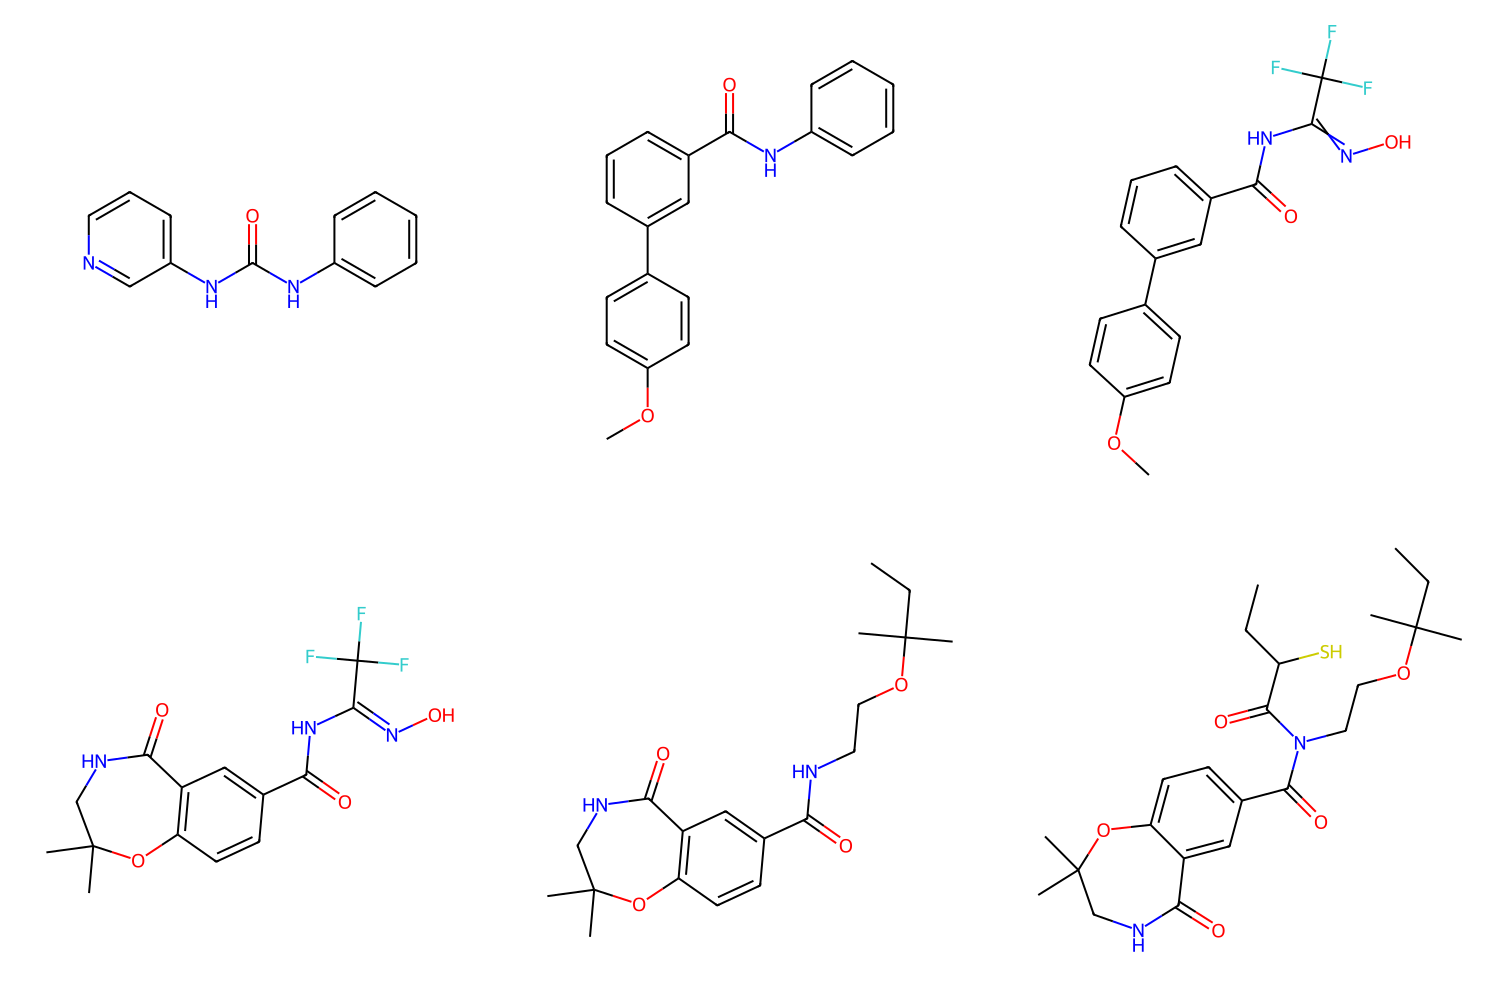

In [14]:
from rdkit.Chem.Draw import MolsToGridImage

molecule = experiment.drug_env.library[1990]
lineage = dg.utils.align_lineage(molecule)

MolsToGridImage([m.mol for m in lineage], subImgSize=(500, 500))